In [ ]:
# Emilie Helen Wolf
# May 1, 2022

# This is Milestone 2 of the GreatLearning Capstone for Housing Price Prediction based on Linear Regression.
# This project demonstrates my ability to prepare a dataset for linear regression.
# Concepts: nulls, outliers, feature extraction, perform eda again, Linearity, normality, homoscedacisity, 

# 🔸 Objective
Predict the housing prices of a town or a suburb based on the features of the locality provided and identify the most important features to consider while predicting the prices.

# 🔸 Data Dictionary
This dataset has 23 features, price being the target variable. The details of all the features are given
below:
- cid: a notation for a house
- dayhours: Date house was sold
- price: Price is prediction target (in US dollars)
- room_bed: Number of Bedrooms per house
- room_bath: Number of bathrooms per bedrooms
- living_measure: square footage of the home
- lot_measure: square footage of the lot
- ceil: Total floors (levels) in house
- coast: House which has a view to a waterfront (0 - No, 1 - Yes)
- sight: Has been viewed
- condition: How good the condition is (Overall out of 5)
- quality: grade given to the housing unit, based on grading system
- ceil_measure: square footage of house apart from basement
- basement_measure: square footage of the basement
- yr_built: Built Year
- yr_renovated: Year when house was renovated
- zipcode: zip code
- lat: Latitude coordinate
- long: Longitude coordinate
- living_measure15: Living room area in 2015 (implies-- some renovations) This might or might not have affected the lot size area
- lot_measure15: lotSize area in 2015 (implies-- some renovations)
- furnished: Based on the quality of room (0 - No, 1 - Yes)
- total_area: Measure of both living and lot

# 🔸 Strategy for Milestone 2
#### A. Make a Rough Draft Model on the Raw Data 
   - to show the inital relevance of the features
   
#### B. Preprocess the Training Set (Feature Engineering)
   1. group categorical data so it's not as granular
        - 5 digit zip code to 3 digit
        - extract month from datetime
   2. check for accurate math that is row-wise (liv+lot=total)
   3. fill in missing values
   4. outlier treatment
   5. combine columns and extract features
   6. remove unwanted columns and add new ones
   7. one-hot-encoding
   8. scaling and variable transformations
   
#### C. Preprocess the Testing Set
   - same as the training set

#### D. Perform EDA on Training Set
   - correlation and heatmap and other insightful visualizations
   - Relationship among variables, important variables
   
#### E. Build Linear Model on Processed Data and Discuss Action Plan

In [136]:
# Automatically structures Python code
%load_ext nb_black

# # to suppress warnings
# import warnings
# warnings.filterwarnings("ignore")

# import standard libraries for manipulating data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# display settings
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
sns.set_style("darkgrid")
sns.set_context("talk")

# for machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Read the XLSX
homes = pd.read_excel("House+Price+Prediction+-+Dataset.xlsx")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

### We already know from the initial anlysis in Milestone 1 that we have missing values, 0's, and '$' signs

## 🔸 Let's make a model from the raw data before processing
- All we are going to do is change all the columns to numeric and drop all the rows with missing values

In [137]:
# Make a copy
df0 = homes.copy()

# drop cid
df0.drop(["cid"], axis=1, inplace=True)

# Convert `dayhours` to datetime and extract the integer value
df0["dayhours"] = pd.to_datetime(df0["dayhours"])
df0["dayhours"] = df0["dayhours"].apply(lambda x: x.value)

# change all '$' to NaN
df0.replace({"$": np.nan}, inplace=True)

# drop all rows with NaN
df0 = df0.dropna()

# check for nulls
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21288 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dayhours          21288 non-null  int64  
 1   price             21288 non-null  int64  
 2   room_bed          21288 non-null  float64
 3   room_bath         21288 non-null  float64
 4   living_measure    21288 non-null  float64
 5   lot_measure       21288 non-null  float64
 6   ceil              21288 non-null  float64
 7   coast             21288 non-null  float64
 8   sight             21288 non-null  float64
 9   condition         21288 non-null  float64
 10  quality           21288 non-null  float64
 11  ceil_measure      21288 non-null  float64
 12  basement          21288 non-null  float64
 13  yr_built          21288 non-null  float64
 14  yr_renovated      21288 non-null  int64  
 15  zipcode           21288 non-null  int64  
 16  lat               21288 non-null  float6

<IPython.core.display.Javascript object>

### Now that we have 21288 complete rows and all are numeric, we can create our first linear regression model.
## This is just a base reference model to see how well we can improve each step.

In [138]:
# Split the data
X = df0.drop(["price"], axis=1)
y = df0["price"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=55
)

# train the model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# print the scores
print(regression_model.score(X_train, y_train))
print(regression_model.score(X_test, y_test))

0.5517593706698771
0.5222668120579332


<IPython.core.display.Javascript object>

# 🔸  Raw Model Observations:

Without doing any sanity checks or feature-engineering, the linear regression model we get from the raw data is **aweful**.
- The training score is 55%
- The testing score is 52%

This tells us that the there is a lot of irrelevent data and we are just as better off predicting every house to be the average value of all houses!

## It will only get better from here!

We already know from our initial analysis that some of these non-ordinal features (such as zipcode) need to be one-hot-encoded and treated as categories. But rather than keeping all 70 zipcodes, we may drop the last 2 numbers of each zip code so there are only a few categories.

We also need to impute the missing values instead of losing entire rows.

We will also be computing the ratio of bathrooms to bedrooms.

Something needs to be done about the renovations as well, so that will be last as it is not as intuitive and needs more thought.

## 🔸 Let's feature-engineer the columns that don't leak data

In [139]:
# make a new copy
df = homes.copy()
# drop cid column
df.drop(["cid"], axis=1, inplace=True)

# change all '$' to NaN
df.replace({"$": np.nan}, inplace=True)

# Convert `dayhours` to datetime
df["dayhours"] = pd.to_datetime(df["dayhours"])
# Extract month from datetime
df["month"] = df["dayhours"].dt.month_name()
df["month"] = df["month"].astype("category")
df.drop(["dayhours"], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   price             21613 non-null  int64   
 1   room_bed          21505 non-null  float64 
 2   room_bath         21505 non-null  float64 
 3   living_measure    21596 non-null  float64 
 4   lot_measure       21571 non-null  float64 
 5   ceil              21541 non-null  float64 
 6   coast             21582 non-null  float64 
 7   sight             21556 non-null  float64 
 8   condition         21528 non-null  float64 
 9   quality           21612 non-null  float64 
 10  ceil_measure      21612 non-null  float64 
 11  basement          21612 non-null  float64 
 12  yr_built          21598 non-null  float64 
 13  yr_renovated      21613 non-null  int64   
 14  zipcode           21613 non-null  int64   
 15  lat               21613 non-null  float64 
 16  long              2157

<IPython.core.display.Javascript object>

## Let's reduce zipcodes into fewer and bigger regions

In [140]:
# drop last digit from each zipcode
df["zip"] = df["zipcode"].apply(lambda x: x // 10)

df["zip"].nunique()

19

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Zip Codes Plotted by Latitude and Longitude')

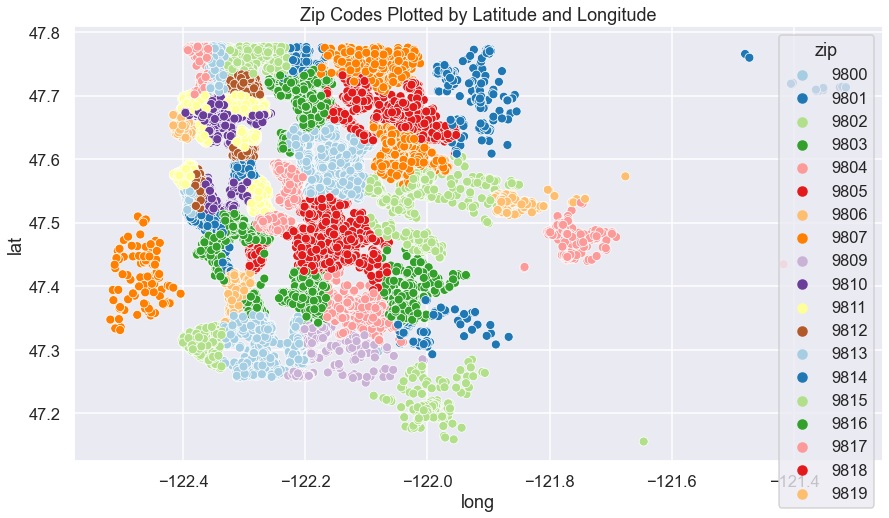

<IPython.core.display.Javascript object>

In [141]:
# What do the zipcode regions look like?
plt.figure(figsize=(14.5, 8))
sns.scatterplot(data=df, x="long", y="lat", hue="zip", palette="Paired")
plt.title("Zip Codes Plotted by Latitude and Longitude")

## There are some problems with this. 
- 19 is still a lot of zip codes
- Zip codes don't seem to group very well this way
    - 9810 (dark purple), 9811 (yellow) and 9812 (brown) are split up and disjointed and hardly look related
    
## Let's divide zip code by 100 instead of 10. Let's change it to fewer regions.

Text(0.5, 1.0, 'Zip Codes Plotted by Latitude and Longitude')

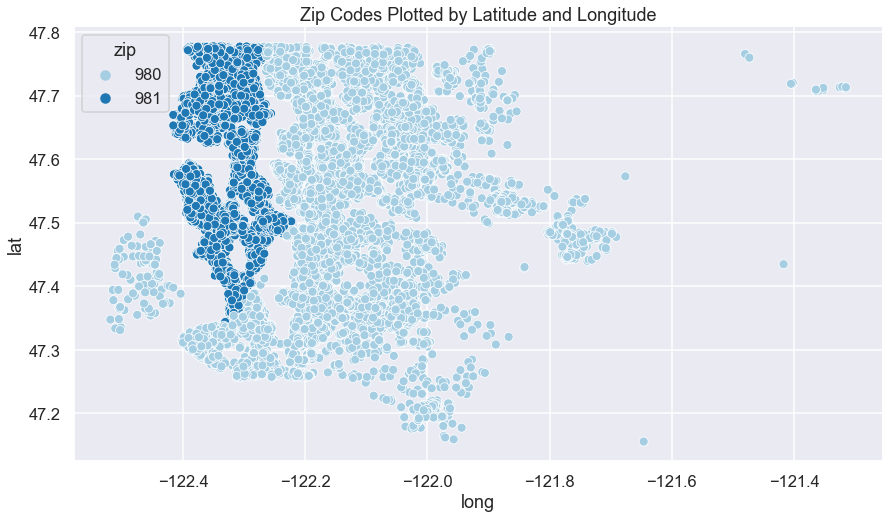

<IPython.core.display.Javascript object>

In [142]:
# drop the last 2 digits from each zipcode
df["zip"] = df["zipcode"].apply(lambda x: x // 100)

plt.figure(figsize=(14.5, 8))
sns.scatterplot(data=df, x="long", y="lat", hue="zip", palette="Paired")
plt.title("Zip Codes Plotted by Latitude and Longitude")

## The regions look distinguishable now.

### 🔸 Let's take care of some missing values by checking for accurate math in each row

In [143]:
# change zip to category and reprint dataframe info
df["zip"] = df["zip"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   price             21613 non-null  int64   
 1   room_bed          21505 non-null  float64 
 2   room_bath         21505 non-null  float64 
 3   living_measure    21596 non-null  float64 
 4   lot_measure       21571 non-null  float64 
 5   ceil              21541 non-null  float64 
 6   coast             21582 non-null  float64 
 7   sight             21556 non-null  float64 
 8   condition         21528 non-null  float64 
 9   quality           21612 non-null  float64 
 10  ceil_measure      21612 non-null  float64 
 11  basement          21612 non-null  float64 
 12  yr_built          21598 non-null  float64 
 13  yr_renovated      21613 non-null  int64   
 14  zipcode           21613 non-null  int64   
 15  lat               21613 non-null  float64 
 16  long              2157

<IPython.core.display.Javascript object>

### Handle row-wise missing values like living, lot, and total area

In [144]:
# Check to see that all the nonnull rows for living and lot measurements DO add up to total area!
(df["living_measure"] + df["lot_measure"] - df["total_area"]).sum()

0.0

<IPython.core.display.Javascript object>

In [145]:
# Impute NaNs for all three unknown variables in living+lot=total
df["total_area"].fillna((df["living_measure"] + df["lot_measure"]), inplace=True)
df["living_measure"].fillna((df["total_area"] - df["lot_measure"]), inplace=True)
df["lot_measure"].fillna((df["total_area"] - df["living_measure"]), inplace=True)

# Impute NaNs in living_measure15 to be equal to original living_measure
df["living_measure15"].fillna(df["living_measure"], inplace=True)
df["lot_measure15"].fillna(df["lot_measure"], inplace=True)

# make new column total_area15
df["total_area15"] = df["living_measure15"] + df["lot_measure15"]

# make new column renovation_percent
df["renovation_percent"] = df["total_area15"] / df["total_area"]

# drop columns
df.drop(
    ["living_measure15", "lot_measure15", "total_area15", "total_area"],
    axis=1,
    inplace=True,
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   price               21613 non-null  int64   
 1   room_bed            21505 non-null  float64 
 2   room_bath           21505 non-null  float64 
 3   living_measure      21613 non-null  float64 
 4   lot_measure         21613 non-null  float64 
 5   ceil                21541 non-null  float64 
 6   coast               21582 non-null  float64 
 7   sight               21556 non-null  float64 
 8   condition           21528 non-null  float64 
 9   quality             21612 non-null  float64 
 10  ceil_measure        21612 non-null  float64 
 11  basement            21612 non-null  float64 
 12  yr_built            21598 non-null  float64 
 13  yr_renovated        21613 non-null  int64   
 14  zipcode             21613 non-null  int64   
 15  lat                 21613 non-null  

<IPython.core.display.Javascript object>

### ✔️date ✔️month ✔️zip ✔️living ✔️lot ✔️total ✔️living15 ✔️lot15 ✔️total15 ✔️renovation_percent

# 🔸 Split the data

In [146]:
# Split the data and look at training set
train0, test0 = train_test_split(df, test_size=0.30, random_state=55)
print(test0.shape)

(6484, 21)


<IPython.core.display.Javascript object>

# Beginning of missing value treatment by looking at nearest neighbors

In [147]:
# Now let's replace the nulls in longitude in the training set
# First make a copy

train = train0.copy()

# Where longitude is null, take all the houses with the same zipcode and similar latitude,
# and then find the average longitude and use that to replace the null

# create a subset of all rows with nulls in the longitude column
longnulls = train[train["long"].isnull()].copy()

# loop thru all rows in subset by index
for x in longnulls.index:

    # temporary variables for the zipcode and latitude of each row
    zipcode = longnulls.at[x, "zipcode"]
    latitude = longnulls.at[x, "lat"].round(2)

    # find the subset of rows in the training set with the same zipcode and latitude and call it neighbors
    neighbors = train[
        (train["zipcode"] == zipcode) & (train["lat"].round(2) == latitude)
    ].copy()

    # find the average longitude of all the neighbors
    longmean = neighbors["long"].mean()

    # fill in the missing longitude with the average of the neighbors
    train.at[x, "long"] = longmean

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15129 entries, 14560 to 4762
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   price               15129 non-null  int64   
 1   room_bed            15050 non-null  float64 
 2   room_bath           15050 non-null  float64 
 3   living_measure      15129 non-null  float64 
 4   lot_measure         15129 non-null  float64 
 5   ceil                15080 non-null  float64 
 6   coast               15104 non-null  float64 
 7   sight               15084 non-null  float64 
 8   condition           15066 non-null  float64 
 9   quality             15128 non-null  float64 
 10  ceil_measure        15128 non-null  float64 
 11  basement            15128 non-null  float64 
 12  yr_built            15118 non-null  float64 
 13  yr_renovated        15129 non-null  int64   
 14  zipcode             15129 non-null  int64   
 15  lat                 15129 non-nul

<IPython.core.display.Javascript object>

### Next, does ceiling + basement = living? How can we handle more missing values?

In [148]:
# Does ceil_measure + basement always equal living_measure? How often do they not add up?
(train["ceil_measure"] + train["basement"] != train["living_measure"]).sum()

1

<IPython.core.display.Javascript object>

Only 1 observation doesn't add up for ceiling and basement, but it's probably the missing value. We will impute it by comparing it to all the basements of the houses that share the same coordinates

In [149]:
train.loc[train["ceil_measure"].isnull()]

price  room_bed  room_bath  living_measure  lot_measure  ceil  coast  \
21226  327500   3.00000    2.25000      2310.00000   7200.00000   NaN    NaN   

       sight  condition  quality  ceil_measure  basement  yr_built  \
21226    NaN        NaN      NaN           NaN       NaN       NaN   

       yr_renovated  zipcode      lat       long  furnished month  zip  \
21226             0    98031 47.40510 -122.19300    0.00000  June  980   

       renovation_percent  
21226             0.96330

<IPython.core.display.Javascript object>

Wow, this row has a lot of nulls. At least we have latitude and longitude. What are the houses closest to 47.40510 and -122.19300?

In [150]:
train.loc[(train["lat"].round(2) == 47.41) & (train["long"].round(2) == -122.19)]

price  room_bed  room_bath  living_measure  lot_measure    ceil  \
12415  320000   4.00000    2.50000      1920.00000   7277.00000 2.00000   
924    295000   4.00000    2.50000      1850.00000   8198.00000 2.00000   
18380  340000   4.00000    2.50000      2360.00000   7475.00000 2.00000   
847    316500   4.00000    2.50000      2150.00000   6807.00000 2.00000   
9777   312000   4.00000    2.25000      1930.00000   7452.00000 1.00000   
21226  327500   3.00000    2.25000      2310.00000   7200.00000     NaN   
3078   312000   4.00000    2.50000      1790.00000  10584.00000 1.00000   

        coast   sight  condition  quality  ceil_measure  basement   yr_built  \
12415 0.00000 0.00000    4.00000  8.00000    1920.00000   0.00000 1990.00000   
924   0.00000 0.00000    3.00000  7.00000    1850.00000   0.00000 1993.00000   
18380 0.00000 0.00000    3.00000  8.00000    2360.00000   0.00000 1992.00000   
847   0.00000 0.00000    4.00000  8.00000    2150.00000   0.00000 1991.00000   
9777  0.00000 0.00000    3.00000  7.00000    1430.00000 500.00000 1984.00000   
21226     NaN     NaN        NaN      NaN           NaN       NaN        NaN   
3078  0.00000 0.00000    4.00000  7.00000    1290.00000 500.00000 1981.00000   

       yr_renovated  zipcode      lat       long  furnished      month  zip  \
12415             0    98031 47.40580 -122.19200    0.00000        May  980   
924               0    98031 47.40790 -122.18600    0.00000       July  980   
18380             0    98031 47.40520 -122.18717    0.00000  September  980   
847               0    98031 47.40530 -122.18900    0.00000        May  980   
9777              0    98031 47.40980 -122.18900    0.00000        May  980   
21226             0    98031 47.40510 -122.19300    0.00000       June  980   
3078              0    98031 47.40610 -122.18800    0.00000      April  980   

       renovation_percent  
12415             1.08133  
924               0.97273  
18380             1.00153  
847               1.02155  
9777              0.95012  
21226             0.96330  
3078              0.87684

<IPython.core.display.Javascript object>

So there are 5 neighboring houses and they are similarly priced and were built in the 80s and 90s.

### We are going to assume that most neighboring houses will be similarly built.

We will impute missing values based on neighboring houses

In [151]:
# Let's create a script...
# For each null in room_bed, room_bath, ceil, coast, sight, condition, quality, yr_built, yr_renovated, and furnished,
# take the latitude and longitude, round them to 1 decimal place,
# subset the houses that also round to the same coordinates,
# and then fill the null with the most frequent integer from the corresponding column

for col in [
    "room_bed",
    "room_bath",
    "ceil",
    "coast",
    "sight",
    "condition",
    "quality",
    "ceil_measure",
    "basement",
    "yr_built",
    "yr_renovated",
    "furnished",
]:
    nulls = train[train[col].isnull()].copy()

    for x in nulls.index:
        lat = nulls.at[x, "lat"].round(1)
        long = nulls.at[x, "long"].round(1)

        neighbors = train[
            (train["lat"].round(1) == lat) & (train["long"].round(1) == long)
        ].copy()

        colfreq = neighbors[col].mode().iat[0]
        train.at[x, col] = colfreq

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15129 entries, 14560 to 4762
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   price               15129 non-null  int64   
 1   room_bed            15129 non-null  float64 
 2   room_bath           15129 non-null  float64 
 3   living_measure      15129 non-null  float64 
 4   lot_measure         15129 non-null  float64 
 5   ceil                15129 non-null  float64 
 6   coast               15129 non-null  float64 
 7   sight               15129 non-null  float64 
 8   condition           15129 non-null  float64 
 9   quality             15129 non-null  float64 
 10  ceil_measure        15129 non-null  float64 
 11  basement            15129 non-null  float64 
 12  yr_built            15129 non-null  float64 
 13  yr_renovated        15129 non-null  int64   
 14  zipcode             15129 non-null  int64   
 15  lat                 15129 non-nul

<IPython.core.display.Javascript object>

## Imputation of mode from neighboring houses
#### ✔️long ✔️bed ✔️bath ✔️ceil ✔️sight ✔️condition ✔️quality ✔️ceil_measure ✔️basement ✔️yr_built ✔️yr_renovated ✔️furnished
### All the missing values in the training set are gone. Now let's do the same thing to the testing set.

In [152]:
test = test0.copy()

longnulls = test[test["long"].isnull()].copy()
for x in longnulls.index:
    zipcode = longnulls.at[x, "zipcode"]
    latitude = longnulls.at[x, "lat"].round(2)
    neighbors = test[
        (test["zipcode"] == zipcode) & (test["lat"].round(2) == latitude)
    ].copy()

    longmean = neighbors["long"].mean()
    test.at[x, "long"] = longmean

for col in [
    "room_bed",
    "room_bath",
    "ceil",
    "coast",
    "sight",
    "condition",
    "quality",
    "ceil_measure",
    "basement",
    "yr_built",
    "yr_renovated",
    "furnished",
]:
    nulls = test[test[col].isnull()].copy()
    for x in nulls.index:
        lat = nulls.at[x, "lat"].round(1)
        long = nulls.at[x, "long"].round(1)

        neighbors = test[
            (test["lat"].round(1) == lat) & (test["long"].round(1) == long)
        ].copy()

        colfreq = neighbors[col].mode().iat[0]
        test.at[x, col] = colfreq

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6484 entries, 20428 to 18776
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   price               6484 non-null   int64   
 1   room_bed            6484 non-null   float64 
 2   room_bath           6484 non-null   float64 
 3   living_measure      6484 non-null   float64 
 4   lot_measure         6484 non-null   float64 
 5   ceil                6484 non-null   float64 
 6   coast               6484 non-null   float64 
 7   sight               6484 non-null   float64 
 8   condition           6484 non-null   float64 
 9   quality             6484 non-null   float64 
 10  ceil_measure        6484 non-null   float64 
 11  basement            6484 non-null   float64 
 12  yr_built            6484 non-null   float64 
 13  yr_renovated        6484 non-null   int64   
 14  zipcode             6484 non-null   int64   
 15  lat                 6484 non-null

<IPython.core.display.Javascript object>

# Missing values for the training and testing sets have been handled.

# 🔸  Now it's time to treat outliers in the training set.
- We have 0's in bed, bath, yr_renovated, and where else?

In [153]:
# show all the rows where bedroom and bath are 0

train.loc[(train["room_bed"] == 0) | (train["room_bath"] == 0)]

price  room_bed  room_bath  living_measure  lot_measure    ceil  \
3286    339950   0.00000    2.50000      2290.00000   8319.00000 2.00000   
8340    320000   0.00000    2.50000      1490.00000   7111.00000 2.00000   
4238    235000   0.00000    0.00000      1470.00000   4800.00000 2.00000   
18596   139950   0.00000    0.00000       844.00000   4269.00000 1.00000   
20355   280000   1.00000    0.00000       600.00000  24501.00000 1.00000   
3155   1300000   0.00000    0.00000      4810.00000  28008.00000 2.00000   
17859   228000   0.00000    1.00000       390.00000   5900.00000 1.00000   
17946    75000   1.00000    0.00000       670.00000  43377.00000 1.00000   
18283   240000   0.00000    2.50000      1810.00000   5669.00000 2.00000   
4730    484000   1.00000    0.00000       690.00000  23244.00000 1.00000   

        coast   sight  condition  quality  ceil_measure  basement   yr_built  \
3286  0.00000 0.00000    3.00000  8.00000    2290.00000   0.00000 1985.00000   
8340  0.00000 0.00000    3.00000  7.00000    1490.00000   0.00000 1999.00000   
4238  0.00000 0.00000    3.00000  7.00000    1470.00000   0.00000 1996.00000   
18596 0.00000 0.00000    4.00000  7.00000     844.00000   0.00000 1913.00000   
20355 0.00000 0.00000    2.00000  3.00000     600.00000   0.00000 1950.00000   
3155  0.00000 0.00000    3.00000 12.00000    4810.00000   0.00000 1990.00000   
17859 0.00000 0.00000    2.00000  4.00000     390.00000   0.00000 1953.00000   
17946 0.00000 0.00000    3.00000  3.00000     670.00000   0.00000 1966.00000   
18283 0.00000 0.00000    3.00000  7.00000    1810.00000   0.00000 2003.00000   
4730  0.00000 0.00000    4.00000  7.00000     690.00000   0.00000 1948.00000   

       yr_renovated  zipcode      lat       long  furnished      month  zip  \
3286              0    98042 47.34730 -122.15100    0.00000   November  980   
8340              0    98065 47.52610 -121.82600    0.00000   February  980   
4238              0    98065 47.52650 -121.82800    0.00000   December  980   
18596             0    98001 47.27810 -122.25000    0.00000      April  980   
20355             0    98045 47.53160 -121.74900    0.00000   November  980   
3155              0    98053 47.66420 -122.06900    1.00000       June  980   
17859             0    98118 47.52600 -122.26100    0.00000    October  981   
17946             0    98022 47.26380 -121.90600    0.00000   February  980   
18283             0    98038 47.34930 -122.05300    0.00000  September  980   
4730              0    98053 47.64290 -121.95500    0.00000  September  980   

       renovation_percent  
3286              1.06051  
8340              0.71794  
4238              1.31738  
18596             2.14747  
20355             0.93777  
3155              1.21278  
17859             1.29889  
17946             0.99989  
18283             1.00214  
4730              0.87658

<IPython.core.display.Javascript object>

It's very possible that a 670sqft, 1-story "house" selling for \\$75,000 doesn't have a bathroom,
BUT it's not as likely that a 4810sqft, 2-story house selling for \\$1,300,000 doesn't have any bedrooms or bathrooms.

Looks like we have to treat these outliers on a case by case approach, so we will do it programmatically.

At the very least, every house must have at least 1 bedroom.

What is the average square footage of houses with different rooms?

In [154]:
# Show 75th percentile of living measurement for each number of bedrooms

train.groupby("room_bed")["living_measure"].quantile(0.75)

room_bed
0.00000    2050.00000
1.00000    1010.00000
2.00000    1440.00000
3.00000    2110.00000
4.00000    2990.00000
5.00000    3600.00000
6.00000    3610.00000
7.00000    4647.50000
8.00000    4035.00000
9.00000    3830.00000
10.00000   3437.50000
11.00000   3000.00000
Name: living_measure, dtype: float64

<IPython.core.display.Javascript object>

### We can use these as thresholds. 
### If a house is less than 1010sqft, then it has 1 bedroom. If a house is less than 1440sqft, then it has 2 bedrooms, etc

In [155]:
bedroom_thresh = train.groupby("room_bed")["living_measure"].quantile(0.75)

# for each row missing a value in bedrooms:
bednulls = train[train["room_bed"] == 0].copy()
for x in bednulls.index:

    # for each item in the Series:
    for i, v in bedroom_thresh.items():

        # if index=0, skip to next item in Series. if index is greater than 7 rooms, break.
        if i == 0:
            continue
        if i > 7:
            break

        # if the living measure is less than value at bedroom index,
        if train.at[x, "living_measure"] < v:
            # then replace the missing bedroom with the index and break out of loop
            train.at[x, "room_bed"] = i
            break

    # if bedroom is still null and is larger than the threshold for 7 bedrooms, fill in with "7"
    if train.at[x, "room_bed"] == 0:
        train.at[x, "room_bed"] = 7

train.loc[(train["room_bed"] == 0) | (train["room_bath"] == 0)]

price  room_bed  room_bath  living_measure  lot_measure    ceil  \
4238    235000   3.00000    0.00000      1470.00000   4800.00000 2.00000   
18596   139950   1.00000    0.00000       844.00000   4269.00000 1.00000   
20355   280000   1.00000    0.00000       600.00000  24501.00000 1.00000   
3155   1300000   7.00000    0.00000      4810.00000  28008.00000 2.00000   
17946    75000   1.00000    0.00000       670.00000  43377.00000 1.00000   
4730    484000   1.00000    0.00000       690.00000  23244.00000 1.00000   

        coast   sight  condition  quality  ceil_measure  basement   yr_built  \
4238  0.00000 0.00000    3.00000  7.00000    1470.00000   0.00000 1996.00000   
18596 0.00000 0.00000    4.00000  7.00000     844.00000   0.00000 1913.00000   
20355 0.00000 0.00000    2.00000  3.00000     600.00000   0.00000 1950.00000   
3155  0.00000 0.00000    3.00000 12.00000    4810.00000   0.00000 1990.00000   
17946 0.00000 0.00000    3.00000  3.00000     670.00000   0.00000 1966.00000   
4730  0.00000 0.00000    4.00000  7.00000     690.00000   0.00000 1948.00000   

       yr_renovated  zipcode      lat       long  furnished      month  zip  \
4238              0    98065 47.52650 -121.82800    0.00000   December  980   
18596             0    98001 47.27810 -122.25000    0.00000      April  980   
20355             0    98045 47.53160 -121.74900    0.00000   November  980   
3155              0    98053 47.66420 -122.06900    1.00000       June  980   
17946             0    98022 47.26380 -121.90600    0.00000   February  980   
4730              0    98053 47.64290 -121.95500    0.00000  September  980   

       renovation_percent  
4238              1.31738  
18596             2.14747  
20355             0.93777  
3155              1.21278  
17946             0.99989  
4730              0.87658

<IPython.core.display.Javascript object>

In [156]:
# median number of bathrooms for different storied houses
train.groupby("ceil")["room_bath"].quantile(0.5)

ceil
1.00000   1.75000
1.50000   1.75000
2.00000   2.50000
2.50000   2.50000
3.00000   2.50000
3.50000   3.00000
Name: room_bath, dtype: float64

<IPython.core.display.Javascript object>

In [157]:
# if ceiling is greater than one, replace 0 bathrooms with 2.5

zero_baths = train.loc[train["room_bath"] == 0].copy()

for x in zero_baths.index:
    if train.at[x, "ceil"] > 1:
        train.at[x, "room_bath"] = 2.5

train.loc[(train["room_bed"] == 0) | (train["room_bath"] == 0)]

price  room_bed  room_bath  living_measure  lot_measure    ceil  \
18596  139950   1.00000    0.00000       844.00000   4269.00000 1.00000   
20355  280000   1.00000    0.00000       600.00000  24501.00000 1.00000   
17946   75000   1.00000    0.00000       670.00000  43377.00000 1.00000   
4730   484000   1.00000    0.00000       690.00000  23244.00000 1.00000   

        coast   sight  condition  quality  ceil_measure  basement   yr_built  \
18596 0.00000 0.00000    4.00000  7.00000     844.00000   0.00000 1913.00000   
20355 0.00000 0.00000    2.00000  3.00000     600.00000   0.00000 1950.00000   
17946 0.00000 0.00000    3.00000  3.00000     670.00000   0.00000 1966.00000   
4730  0.00000 0.00000    4.00000  7.00000     690.00000   0.00000 1948.00000   

       yr_renovated  zipcode      lat       long  furnished      month  zip  \
18596             0    98001 47.27810 -122.25000    0.00000      April  980   
20355             0    98045 47.53160 -121.74900    0.00000   November  980   
17946             0    98022 47.26380 -121.90600    0.00000   February  980   
4730              0    98053 47.64290 -121.95500    0.00000  September  980   

       renovation_percent  
18596             2.14747  
20355             0.93777  
17946             0.99989  
4730              0.87658

<IPython.core.display.Javascript object>

### Now that we've taken care of the zeros in bedrooms and bathrooms in the training set, let's do the same thing to the testing set.

In [158]:
bedroom_thresh = test.groupby("room_bed")["living_measure"].quantile(0.75)

# for each row missing a value in bedrooms:
bednulls = test[test["room_bed"] == 0].copy()
for x in bednulls.index:

    # for each item in the Series:
    for i, v in bedroom_thresh.items():

        # if index=0, skip to next item in Series. if index is greater than 7 rooms, break.
        if i == 0:
            continue
        if i > 7:
            break

        # if the living measure is less than value at bedroom index,
        if test.at[x, "living_measure"] < v:
            # then replace the missing bedroom with the index and break out of loop
            test.at[x, "room_bed"] = i
            break

    # if bedroom is still null and is larger than the threshold for 7 bedrooms, fill in with "7"
    if test.at[x, "room_bed"] == 0:
        test.at[x, "room_bed"] = 7


# if ceiling is greater than one, replace 0 bathrooms with 2.5
zero_baths = test.loc[test["room_bath"] == 0].copy()

for x in zero_baths.index:
    if test.at[x, "ceil"] > 1:
        test.at[x, "room_bath"] = 2.5

test.loc[(test["room_bed"] == 0) | (test["room_bath"] == 0)]

price  room_bed  room_bath  living_measure  lot_measure    ceil  \
3405  142000   1.00000    0.00000       290.00000  20875.00000 1.00000   

       coast   sight  condition  quality  ceil_measure  basement   yr_built  \
3405 0.00000 0.00000    1.00000  1.00000     290.00000   0.00000 1963.00000   

      yr_renovated  zipcode      lat       long  furnished      month  zip  \
3405             0    98024 47.53080 -121.88800    0.00000  September  980   

      renovation_percent  
3405             1.15615

<IPython.core.display.Javascript object>

## The only zeros remaining now are in basement and yr_renovated

# Let's change yr_renovated to binary and let's make ratios and combine
### bath to bed ratio, basement to ceiling, drop columns, and do the same thing to test set

In [159]:
# Change yr_renovated to 0s and 1s
train.loc[train["yr_renovated"] != 0, "yr_renovated"] = 1

# make new bath ratio column
train["bath2bed_ratio"] = train["room_bath"] / train["room_bed"]
train["basement_ratio"] = train["basement"] / train["ceil_measure"]

# drop the columns we don't need anymore
train.drop(
    ["room_bed", "room_bath", "ceil_measure", "basement", "zipcode", "lat", "long"],
    axis=1,
    inplace=True,
)

test.loc[test["yr_renovated"] != 0, "yr_renovated"] = 1
test["bath2bed_ratio"] = test["room_bath"] / test["room_bed"]
test["basement_ratio"] = test["basement"] / test["ceil_measure"]
test.drop(
    ["room_bed", "room_bath", "ceil_measure", "basement", "zipcode", "lat", "long"],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

# Outliers done. Feature extraction and removal done.

### Let's do a pairplot and correlation heat map before doing one-hot-encoding and scaling


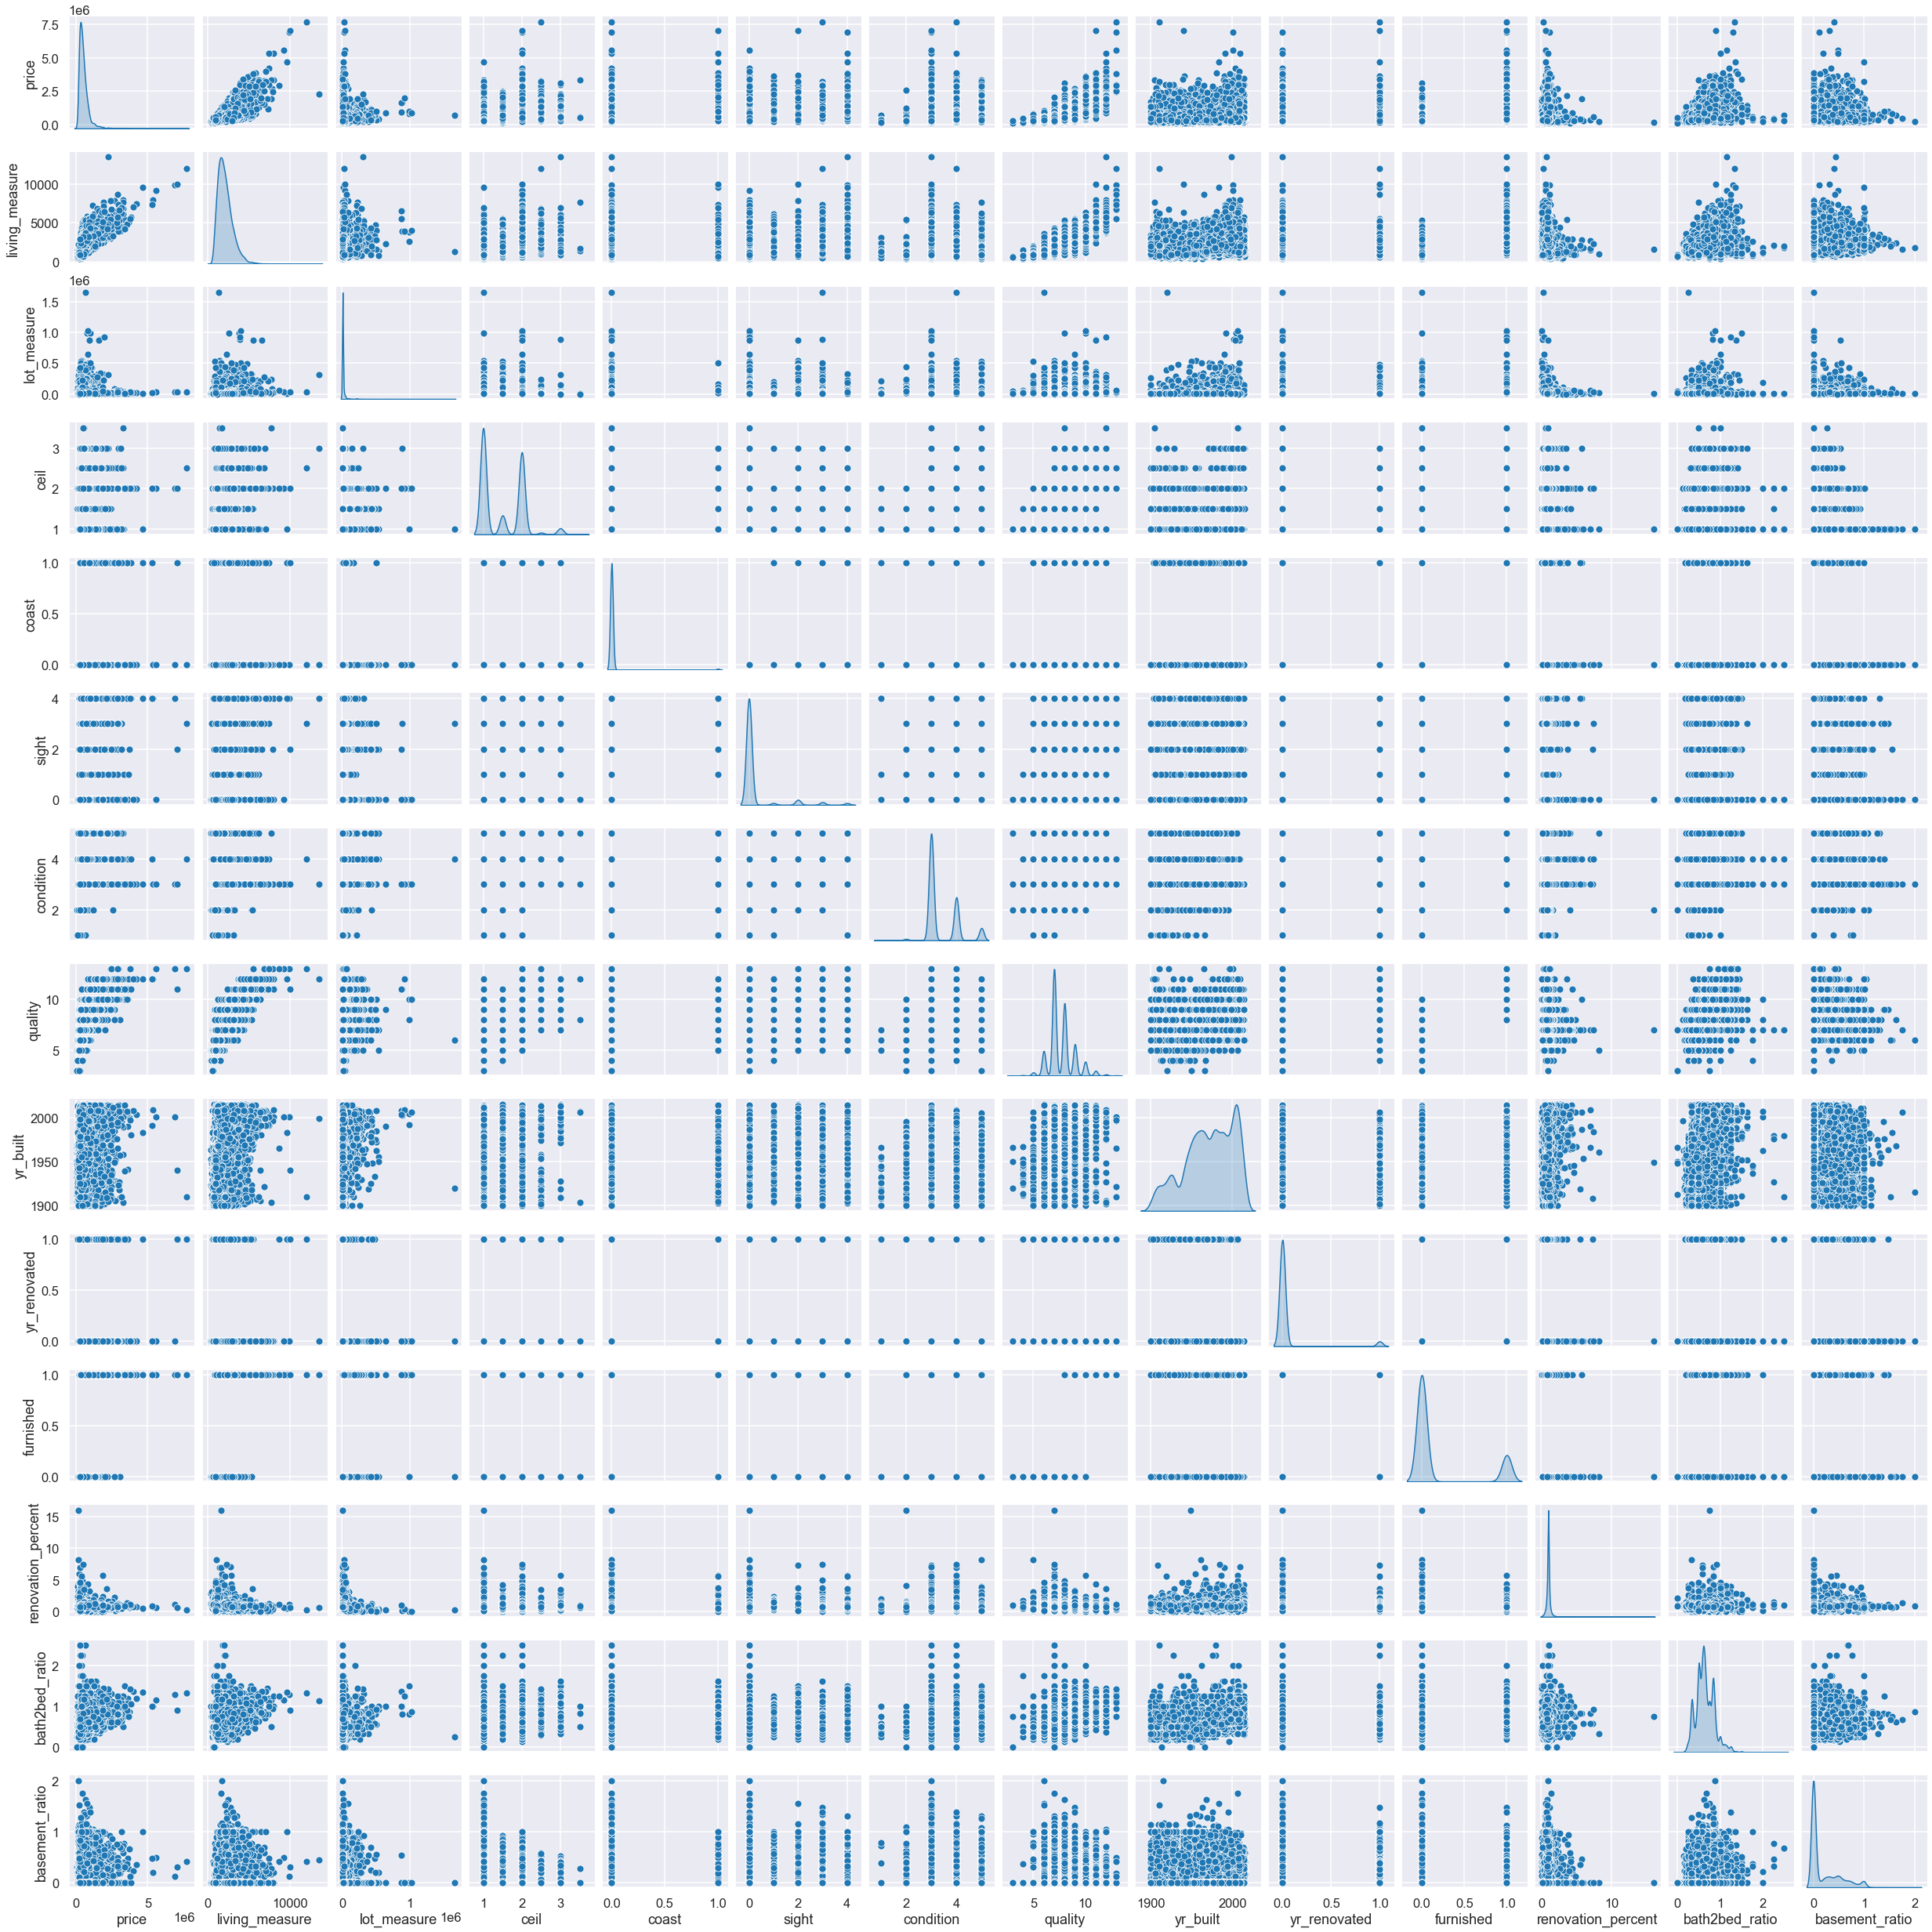

<IPython.core.display.Javascript object>

In [160]:
sns.pairplot(train, diag_kind="kde")

Text(0.5, 1.0, 'Correlation Coefficients of Numerical Variables')

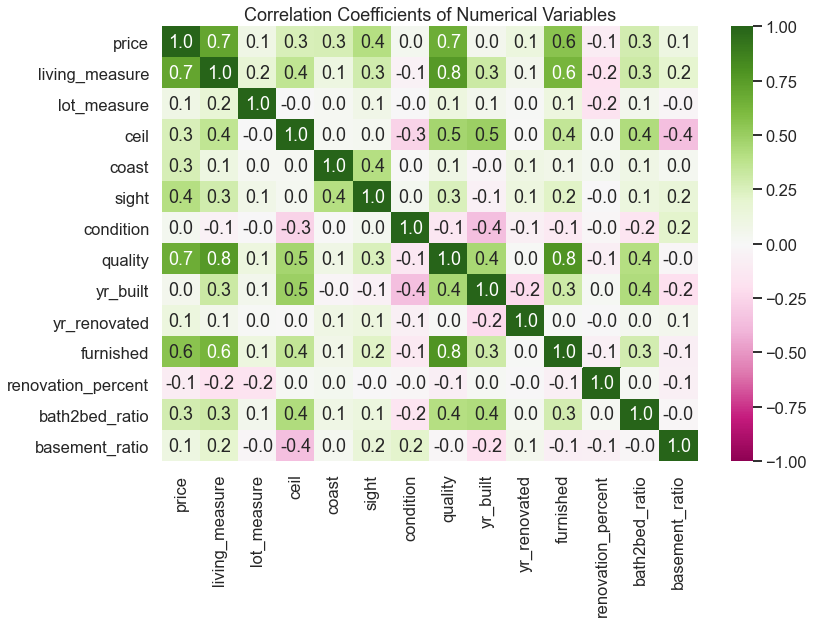

<IPython.core.display.Javascript object>

In [161]:
# Correlations

plt.figure(figsize=(12, 8))
sns.heatmap(
    train.corr(), annot=True, vmin=-1, vmax=1, cmap="PiYG", fmt=".1f",
)
plt.title("Correlation Coefficients of Numerical Variables")

## Observations:
- We started with 22 features and now we have 16 before one-hot-encoding
- `quality` is significantly correlated with `price`,`living_measure`, and `furnished`
- Surprisingly, `renovation_percent` doesn't have a strong correlation with the target variable at all

## Let's one-hot-encode the training and test sets and look at the heatmap again

In [162]:
train = pd.get_dummies(data=train, columns=["month", "zip"], drop_first=True)
test = pd.get_dummies(data=test, columns=["month", "zip"], drop_first=True)

<IPython.core.display.Javascript object>

<ipython-input-163-b9270df4d097>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f2, (ax_box2, ax_hist2) = plt.subplots(


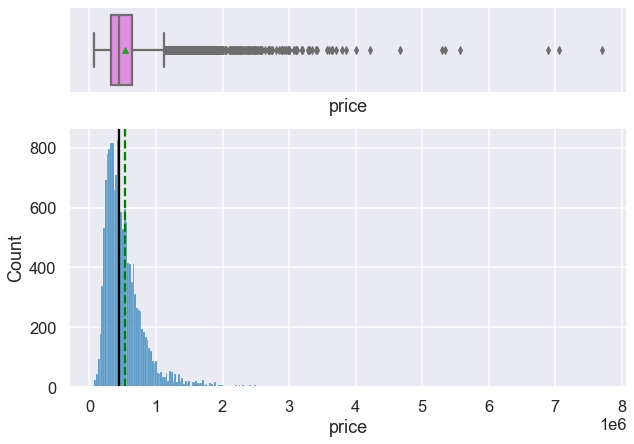

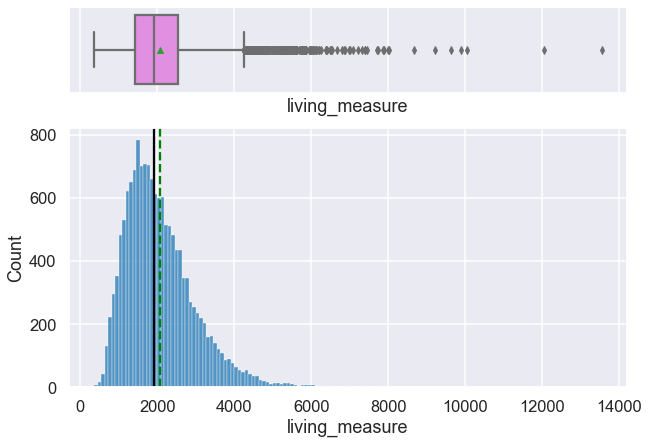

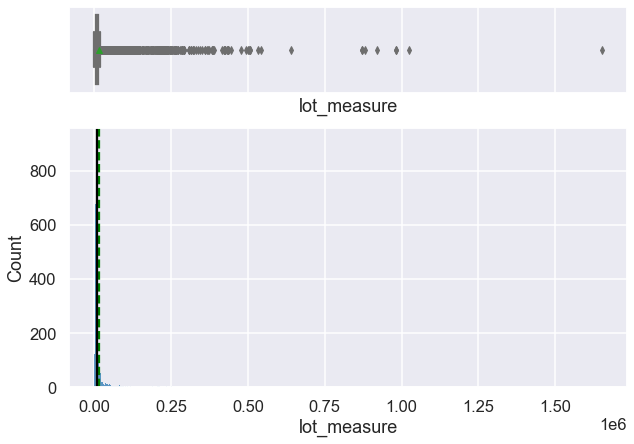

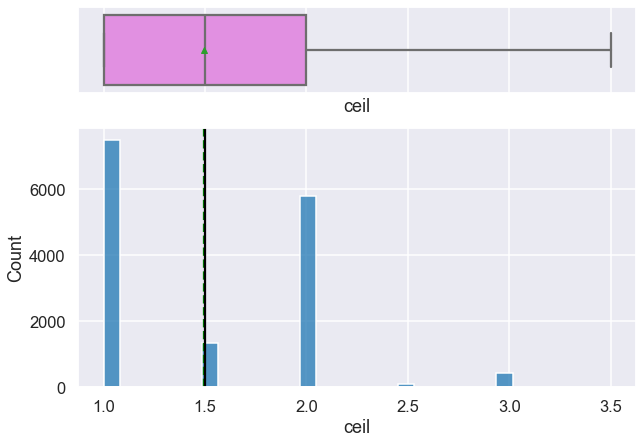

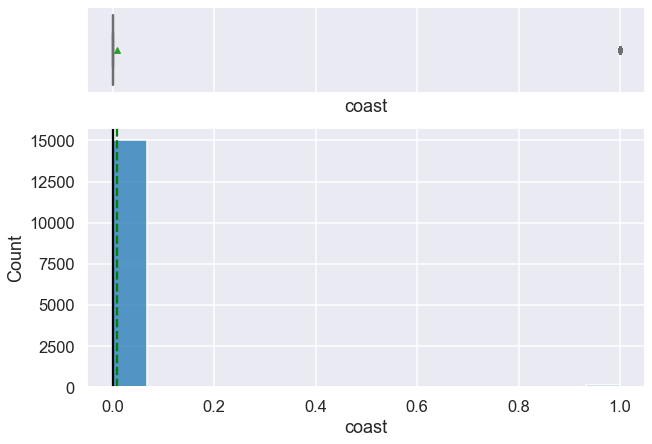

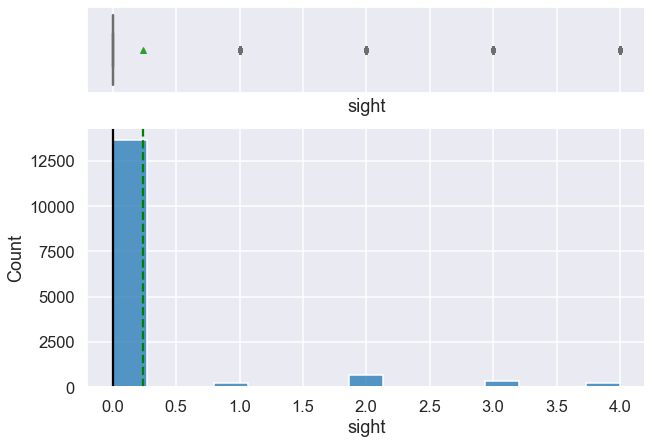

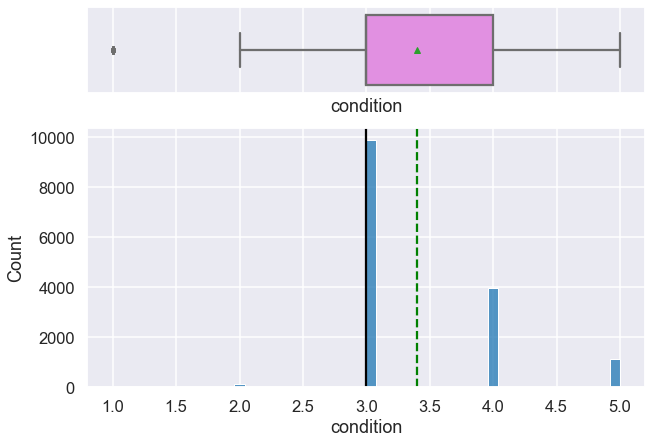

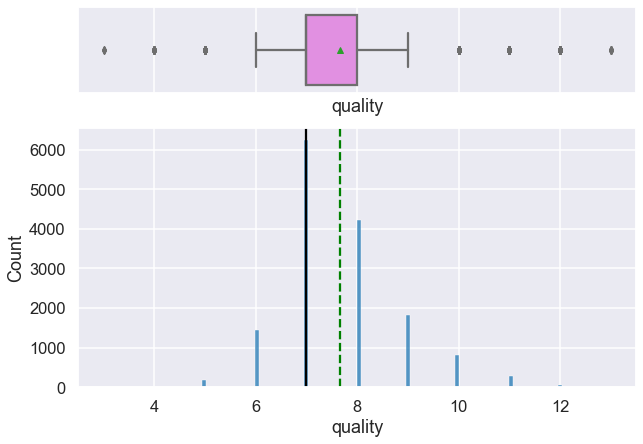

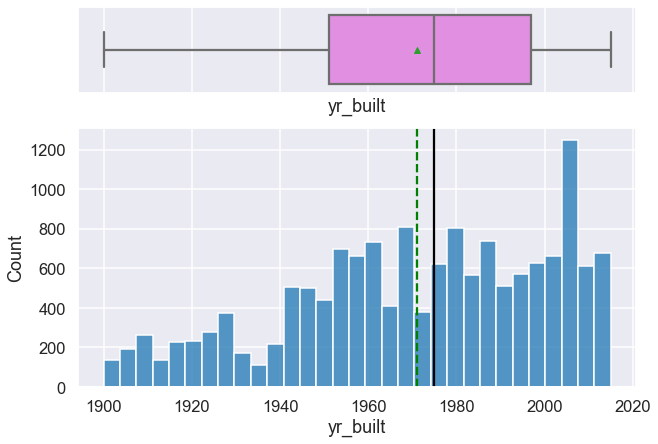

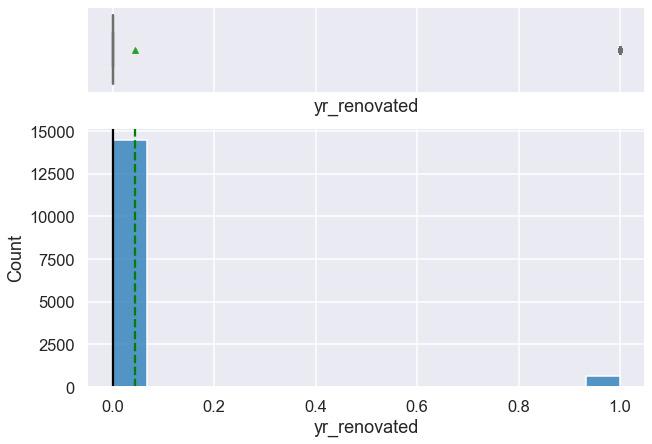

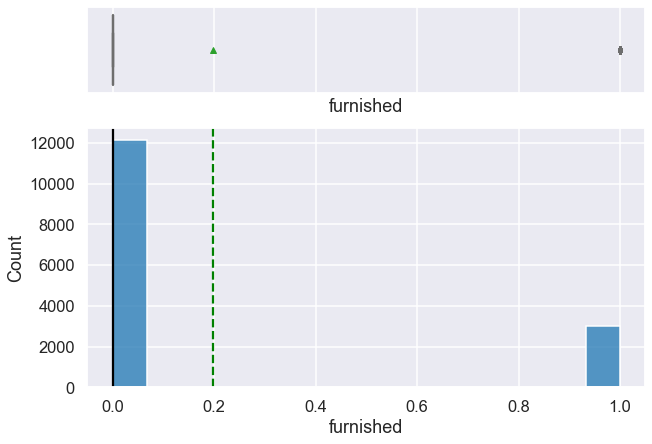

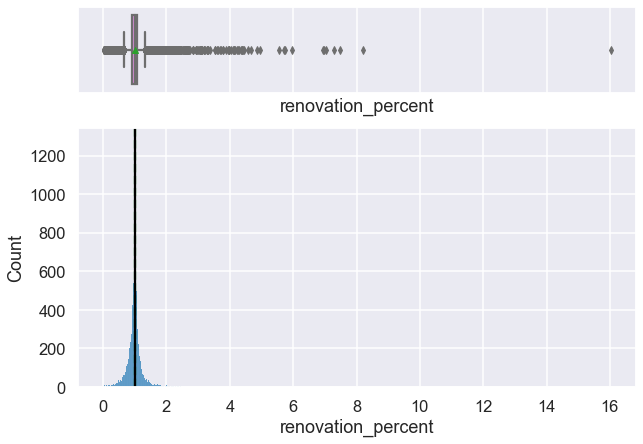

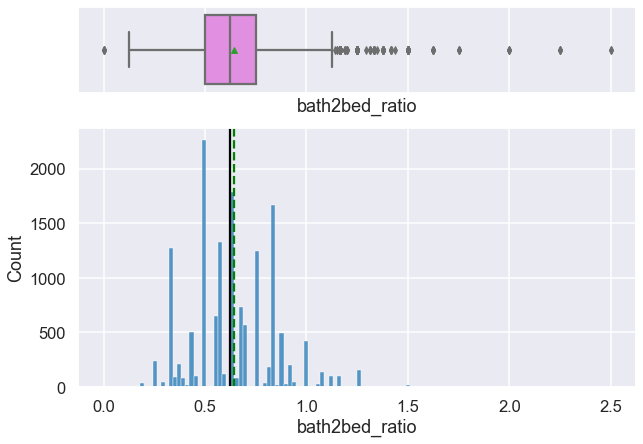

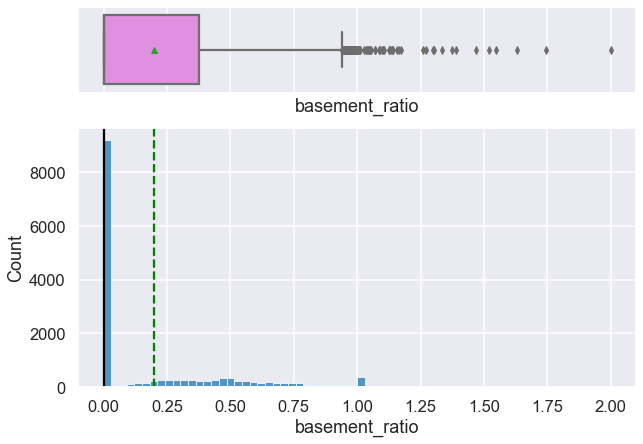

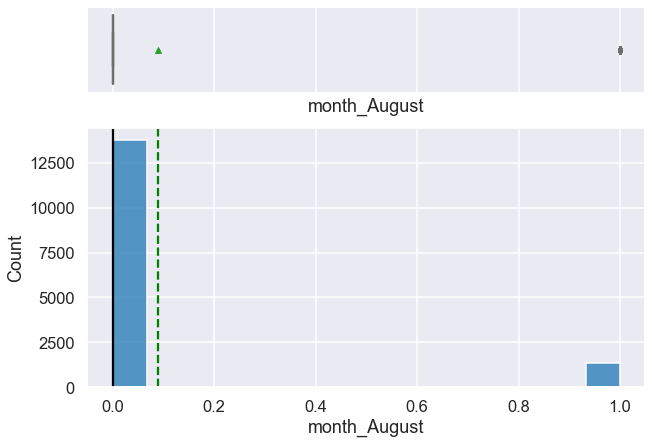

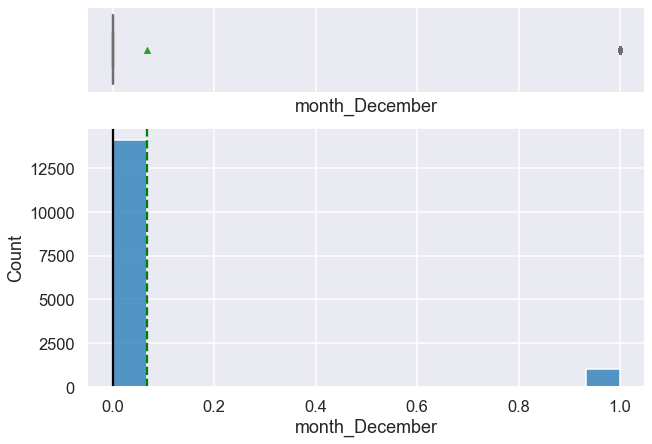

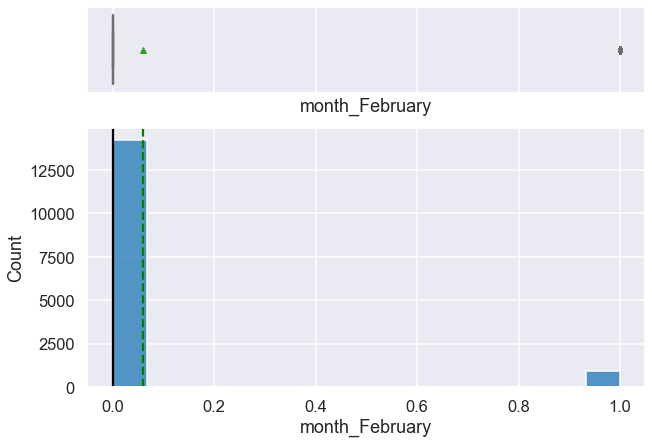

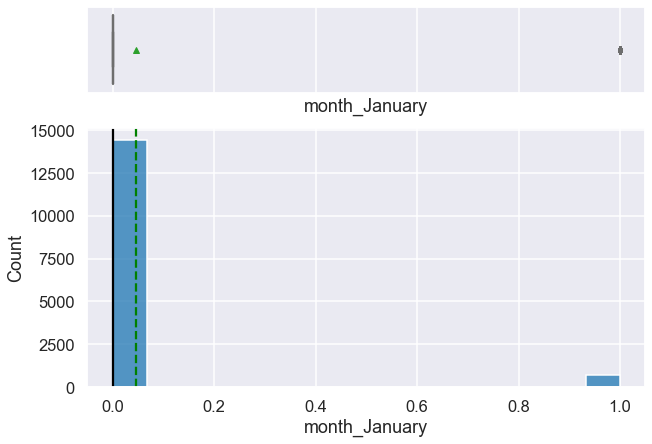

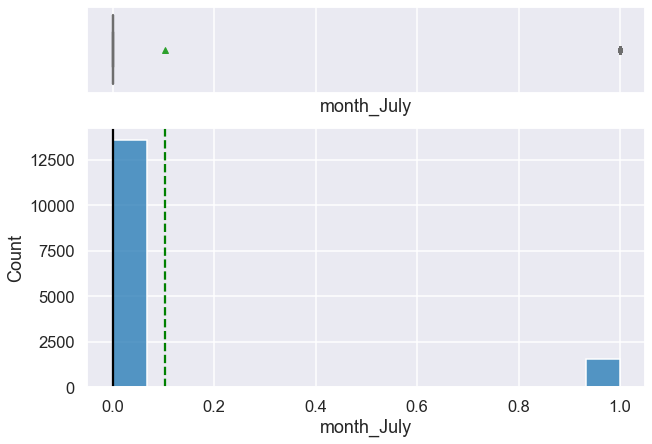

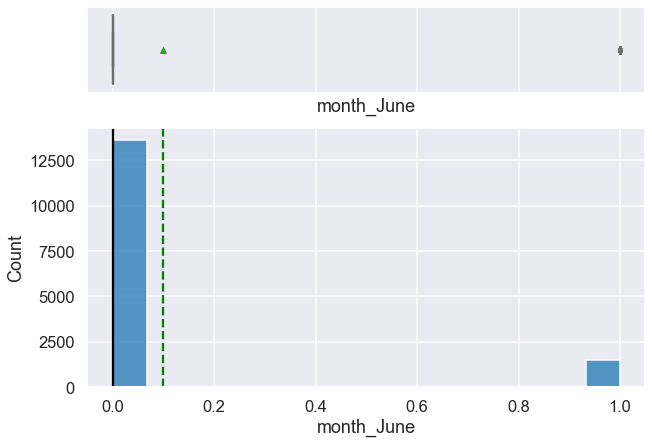

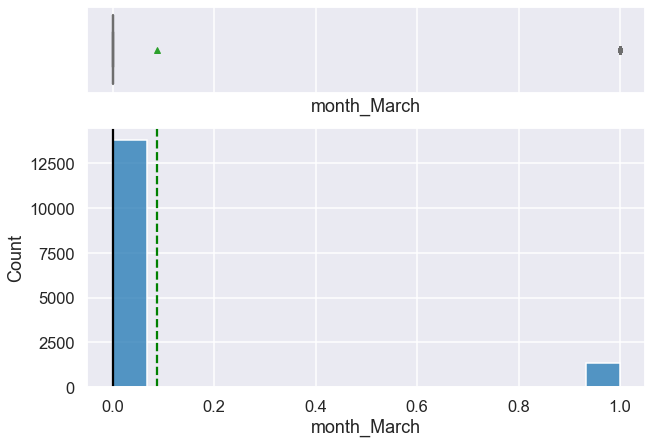

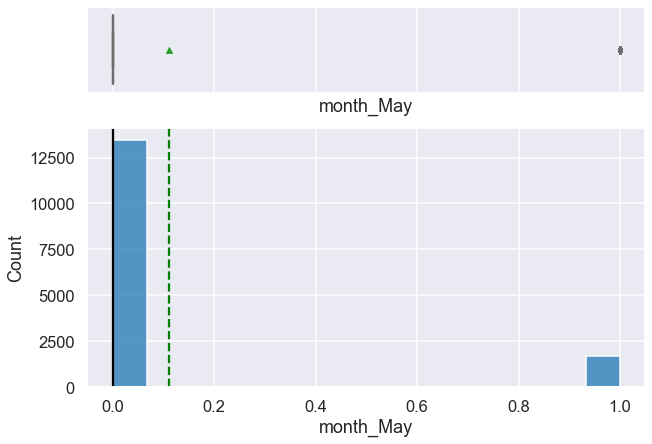

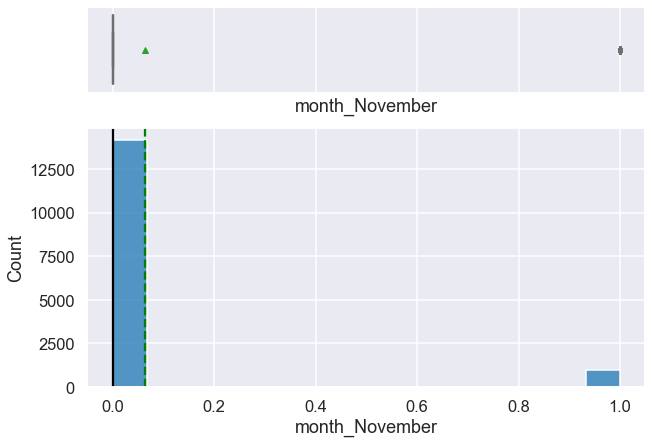

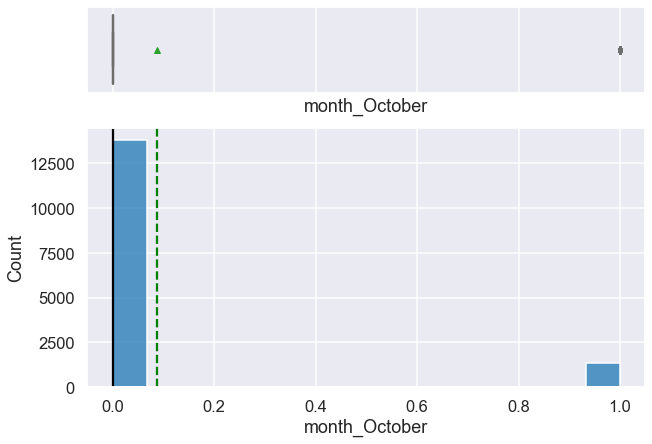

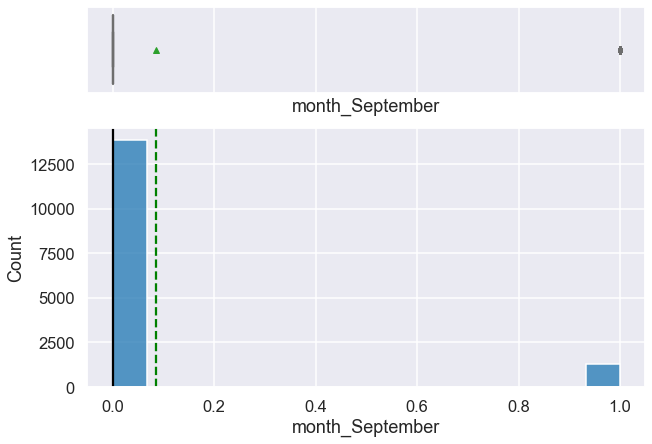

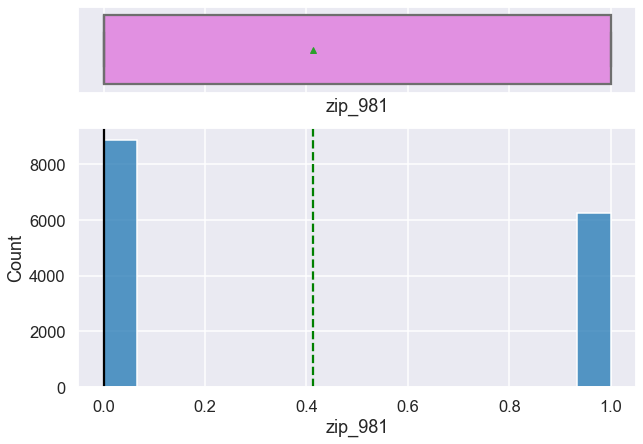

<IPython.core.display.Javascript object>

In [163]:
# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(10, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram


for feature in train.columns:
    histogram_boxplot(
        train, feature, figsize=(10, 7), kde=False, bins=None,
    )

## Now to apply natural log to price, living, and lot in both training and test sets



In [164]:
train['price'] = np.log(train['price'])
train['living_measure'] = np.log(train['living_measure'])
train['lot_measure'] = np.log(train['lot_measure'])

test['price'] = np.log(test['price'])
test['living_measure'] = np.log(test['living_measure'])
test['lot_measure'] = np.log(test['lot_measure'])


<IPython.core.display.Javascript object>

In [165]:
# export copies of the proessed data
train.to_csv("train.csv")
test.to_csv("test.csv")

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='price', ylabel='Count'>

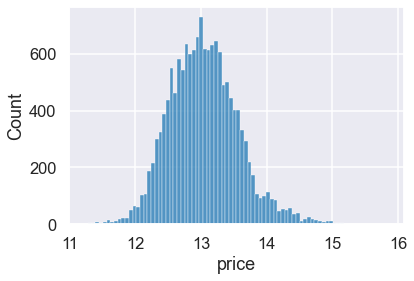

<IPython.core.display.Javascript object>

In [166]:
sns.histplot(data=train, x="price")

Text(0.5, 1.0, 'Correlation Coefficients of Numerical Variables')

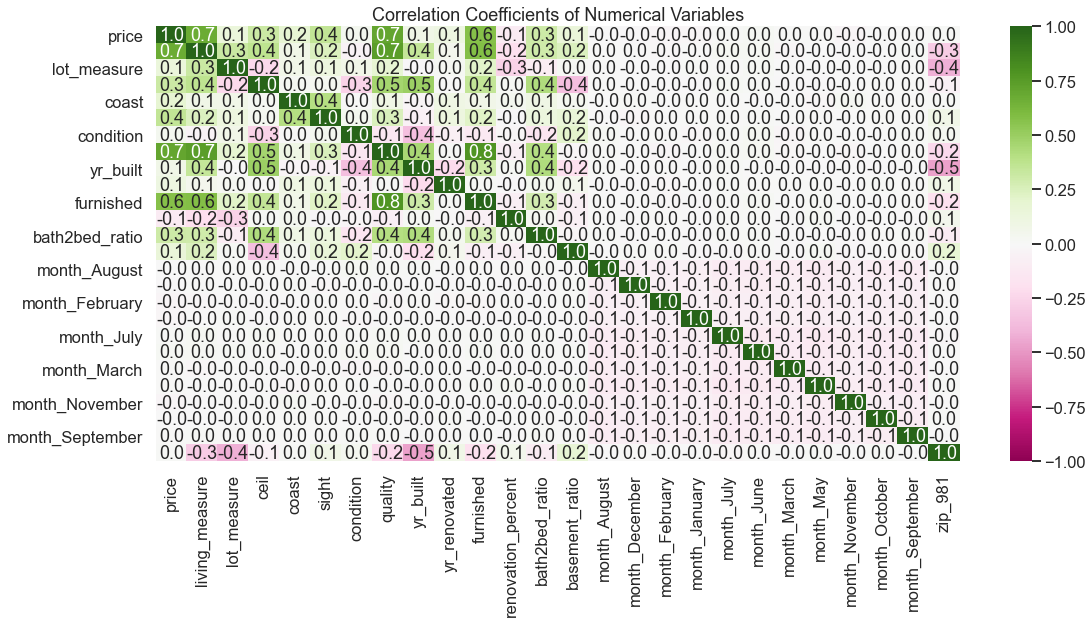

<IPython.core.display.Javascript object>

In [167]:
plt.figure(figsize=(18, 8))
sns.heatmap(
    train.corr(), annot=True, vmin=-1, vmax=1, cmap="PiYG", fmt=".1f",
)
plt.title("Correlation Coefficients of Numerical Variables")

# Let's do a linear model on our processed data

In [168]:
X_train = train.drop(["price"], axis=1)
y_train = train["price"].copy()

X_test = test.drop(["price"], axis=1)
y_test = test["price"].copy()

# train the model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# print the scores
print(regression_model.score(X_train, y_train))
print(regression_model.score(X_test, y_test))

0.6641436644771674
0.64397147561846


<IPython.core.display.Javascript object>

# Observations

The good news is that the model is generalized and isn't overfitting.
The bad news is that the model is only 64% accurate

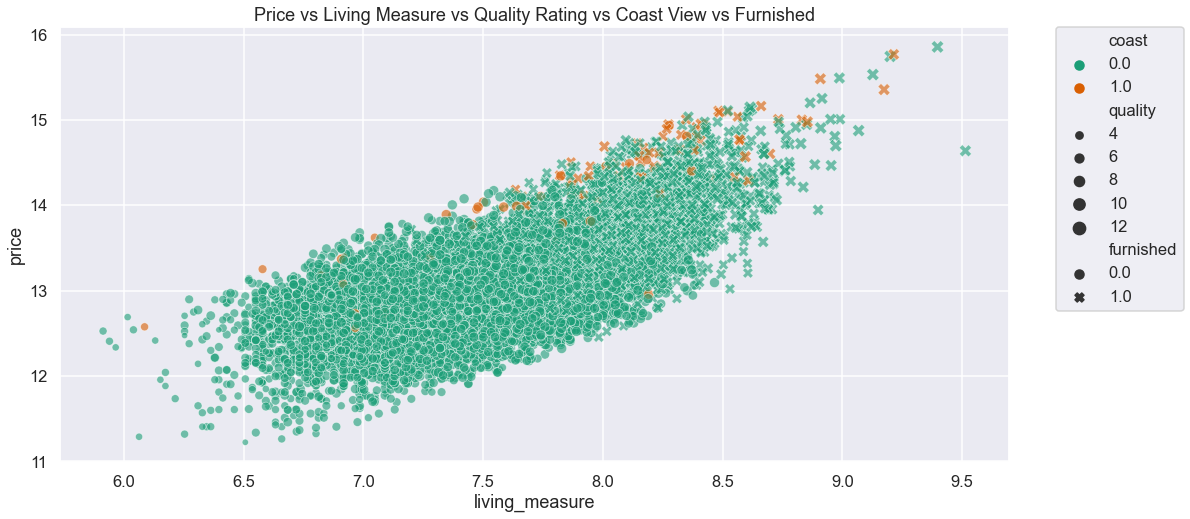

<IPython.core.display.Javascript object>

In [169]:
plt.figure(figsize=(17, 8))

sns.scatterplot(
    data=train,
    y="price",
    palette="Dark2",
    alpha=0.6,
    legend="brief",
    x="living_measure",
    hue="coast",
    style="furnished",
    size="quality",
)
plt.title("Price vs Living Measure vs Quality Rating vs Coast View vs Furnished")
plt.legend(
    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0,
)


Text(0.5, 1.0, 'Price vs Bath2Bed Ratio vs Renovated vs Furnished')

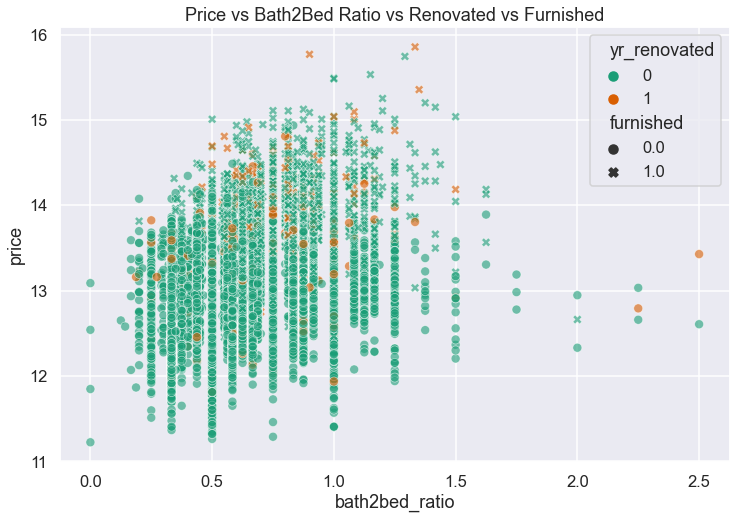

<IPython.core.display.Javascript object>

In [170]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=train,
    y="price",
    palette="Dark2",
    alpha=0.6,
    legend="brief",
    x="bath2bed_ratio",
    style="furnished",
    hue="yr_renovated",
)
plt.title("Price vs Bath2Bed Ratio vs Renovated vs Furnished")



# Observations
- It's hard to say if all these new features helped reduce noise at all. 
- We did not introduce any new data such as school proximity or median income
- All we did was combine the current variables
- In the next milestone, we will do regularization (Lasso or Ridge) and VIF and Significance tests to try and optimize the linear model more.
- The ultimate goal is designing a linear regression model that is not too complex (overfitting) and has very low error in production so that clients can spend less time readjusting home prices, and more time living their lives.